In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


from gensim.models import Word2Vec
from time import time 
import multiprocessing
import logging  # logger
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

import os

In [16]:
data_file_path = os.path.abspath(os.path.join(os.pardir,'data','cleaned_AG.csv'))
data = pd.read_csv(data_file_path)
data.head()

,News Category,Documents,Word Count,Noun Phrases,Noun Count,Adjective Count,Verb Count
0,business,wall st bear claw back black reuters reuters short seller wall street dwindling band ultra cynic seeing green,18,4,12,3,2
1,business,carlyle look toward commercial aerospace reuters reuters private investment firm carlyle group reputation making well timed occasionally controversial play defense industry quietly placed bet another part market,27,5,15,4,3
2,business,oil economy cloud stock outlook reuters reuters soaring crude price plus worry economy outlook earnings expected hang stock market next week depth summer doldrums,24,5,17,4,2
3,business,iraq halt oil export main southern pipeline reuters reuters authority halted oil export flow main pipeline southern iraq intelligence showed rebel militia strike infrastructure oil official said saturday,28,3,19,6,3
4,business,oil price soar time record posing new menace economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month presidential election,28,4,16,7,3


# Drop Title & Description

In [17]:
data['Documents'] = data['Documents'].str.split(" ")
data.head()

,News Category,Documents,Word Count,Noun Phrases,Noun Count,Adjective Count,Verb Count
0,business,"[wall, st, bear, claw, back, black, reuters, reuters, short, seller, wall, street, dwindling, band, ultra, cynic, seeing, green]",18,4,12,3,2
1,business,"[carlyle, look, toward, commercial, aerospace, reuters, reuters, private, investment, firm, carlyle, group, reputation, making, well, timed, occasionally, controversial, play, defense, industry, quietly, placed, bet, another, part, market]",27,5,15,4,3
2,business,"[oil, economy, cloud, stock, outlook, reuters, reuters, soaring, crude, price, plus, worry, economy, outlook, earnings, expected, hang, stock, market, next, week, depth, summer, doldrums]",24,5,17,4,2
3,business,"[iraq, halt, oil, export, main, southern, pipeline, reuters, reuters, authority, halted, oil, export, flow, main, pipeline, southern, iraq, intelligence, showed, rebel, militia, strike, infrastructure, oil, official, said, saturday]",28,3,19,6,3
4,business,"[oil, price, soar, time, record, posing, new, menace, economy, afp, afp, tearaway, world, oil, price, toppling, record, straining, wallet, present, new, economic, menace, barely, three, month, presidential, election]",28,4,16,7,3


# Word Embeddings using Word2Vec algorithm

In [18]:
cores = multiprocessing.cpu_count()

# initializing word2vec model
model = Word2Vec(min_count=20,
                     window=2, # window size for context 
                     vector_size=100,  # no of features 
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

INFO - 21:02:42: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.03)', 'datetime': '2021-04-29T21:02:42.685047', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]', 'platform': 'Linux-4.15.0-142-generic-x86_64-with-glibc2.10', 'event': 'created'}


In [19]:
t = time()

# build vocabulary
model.build_vocab(data['Documents'], progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:02:42: collecting all words and their counts
INFO - 21:02:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:02:42: PROGRESS: at sentence #10000, processed 273130 words, keeping 18981 word types
INFO - 21:02:43: PROGRESS: at sentence #20000, processed 542961 words, keeping 26350 word types
INFO - 21:02:43: PROGRESS: at sentence #30000, processed 810845 words, keeping 31364 word types
INFO - 21:02:43: PROGRESS: at sentence #40000, processed 1079542 words, keeping 35363 word types
INFO - 21:02:43: PROGRESS: at sentence #50000, processed 1347719 words, keeping 38795 word types
INFO - 21:02:43: PROGRESS: at sentence #60000, processed 1617217 words, keeping 42012 word types
INFO - 21:02:43: PROGRESS: at sentence #70000, processed 1887970 words, keeping 44832 word types
INFO - 21:02:43: PROGRESS: at sentence #80000, processed 2156362 words, keeping 47460 word types
INFO - 21:02:43: PROGRESS: at sentence #90000, processed 2420763 words, keeping 50103 wor

Time to build vocab: 0.01 mins


In [20]:
t = time()

#train word2vec model 
model.train(data['Documents'], total_examples=model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:02:43: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 12033 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2', 'datetime': '2021-04-29T21:02:43.739408', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]', 'platform': 'Linux-4.15.0-142-generic-x86_64-with-glibc2.10', 'event': 'train'}
INFO - 21:02:44: EPOCH 1 - PROGRESS: at 47.62% examples, 945607 words/s, in_qsize 13, out_qsize 0
INFO - 21:02:45: EPOCH 1 - PROGRESS: at 98.05% examples, 960916 words/s, in_qsize 7, out_qsize 0
INFO - 21:02:45: worker thread finished; awaiting finish of 6 more threads
INFO - 21:02:45: worker thread finished; awaiting finish of 5 more threads
INFO - 21:02:45: worker thread finished; awaiting finish of 4 more threads
INFO - 21:02:45: worker thread finished; awaiting finish of 3 more threads
INFO - 21:02:45: worker thread finished; awaiting finish of 2 more threads
INFO - 21:02:45: worker thread finished; awaiting fi

INFO - 21:03:05: worker thread finished; awaiting finish of 5 more threads
INFO - 21:03:05: worker thread finished; awaiting finish of 4 more threads
INFO - 21:03:05: worker thread finished; awaiting finish of 3 more threads
INFO - 21:03:05: worker thread finished; awaiting finish of 2 more threads
INFO - 21:03:05: worker thread finished; awaiting finish of 1 more threads
INFO - 21:03:05: worker thread finished; awaiting finish of 0 more threads
INFO - 21:03:05: EPOCH - 11 : training on 3420491 raw words (1975856 effective words) took 2.0s, 1012253 effective words/s
INFO - 21:03:06: EPOCH 12 - PROGRESS: at 52.50% examples, 1043854 words/s, in_qsize 13, out_qsize 0
INFO - 21:03:06: worker thread finished; awaiting finish of 6 more threads
INFO - 21:03:06: worker thread finished; awaiting finish of 5 more threads
INFO - 21:03:06: worker thread finished; awaiting finish of 4 more threads
INFO - 21:03:06: worker thread finished; awaiting finish of 3 more threads
INFO - 21:03:06: worker thr

INFO - 21:03:25: worker thread finished; awaiting finish of 5 more threads
INFO - 21:03:25: worker thread finished; awaiting finish of 4 more threads
INFO - 21:03:25: worker thread finished; awaiting finish of 3 more threads
INFO - 21:03:25: worker thread finished; awaiting finish of 2 more threads
INFO - 21:03:25: worker thread finished; awaiting finish of 1 more threads
INFO - 21:03:25: worker thread finished; awaiting finish of 0 more threads
INFO - 21:03:25: EPOCH - 22 : training on 3420491 raw words (1974346 effective words) took 1.8s, 1089539 effective words/s
INFO - 21:03:26: EPOCH 23 - PROGRESS: at 55.72% examples, 1101023 words/s, in_qsize 13, out_qsize 1
INFO - 21:03:27: worker thread finished; awaiting finish of 6 more threads
INFO - 21:03:27: worker thread finished; awaiting finish of 5 more threads
INFO - 21:03:27: worker thread finished; awaiting finish of 4 more threads
INFO - 21:03:27: worker thread finished; awaiting finish of 3 more threads
INFO - 21:03:27: worker thr

Time to train the model: 0.93 mins


In [21]:
# save model
model.save('model.bin')

INFO - 21:03:39: Word2Vec lifecycle event {'fname_or_handle': 'model.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-04-29T21:03:39.342575', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]', 'platform': 'Linux-4.15.0-142-generic-x86_64-with-glibc2.10', 'event': 'saving'}
INFO - 21:03:39: not storing attribute cum_table
INFO - 21:03:39: saved model.bin


# Feature Extraction (word2vec)

Base line number of features = 100

In [22]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index_to_key)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model.wv[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(words, model, num_features):
    """
    Calculate average feature vectors for all headlines 
    """
    counter = 0
    feature_vecs = np.zeros((len(words),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for word in words:
        feature_vecs[counter] = make_feature_vec(word, model, num_features)
        counter = counter + 1
    return feature_vecs

In [23]:
word2vec = get_avg_feature_vecs(data['Documents'], model, 100)

In [24]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x,y in np.argwhere(np.isnan(word2vec))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    word2vec = np.delete(word2vec, nan_indices, axis=0)
    word2vec.drop(data.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert word2vec.shape[0] == len(data)

In [25]:
w2v = pd.DataFrame(word2vec)

data.reset_index(drop=True, inplace=True)
w2v.reset_index(drop=True, inplace=True)
#df = pd.concat([df1, df2], axis=1)
w2v = pd.concat([data[['News Category','Word Count','Noun Phrases','Noun Count',
                                         'Adjective Count','Verb Count']],w2v],axis=1)

w2v

,News Category,Word Count,Noun Phrases,Noun Count,Adjective Count,Verb Count,0,1,2,3,...,90,91,92,93,94,95,96,97,98,99
0,business,18,4,12,3,2,0.355217,-0.041954,0.470165,0.467087,...,0.469709,-0.170905,-0.112577,-0.197271,0.330662,-0.147216,-0.045830,-0.090750,-0.137804,-0.459132
1,business,27,5,15,4,3,0.247009,-0.315144,0.267489,0.120730,...,0.038810,-0.064230,-0.311590,-0.050263,-0.071159,-0.690443,-0.237539,-0.006161,0.062806,-0.133533
2,business,24,5,17,4,2,0.396499,-0.400545,0.478822,0.431972,...,0.421601,-0.737285,-0.396258,0.262834,-0.204615,0.204761,0.768816,0.434184,0.069389,-0.585188
3,business,28,3,19,6,3,-0.583359,-0.813260,0.163460,-0.306104,...,0.212820,-0.644868,-0.730603,0.202158,-0.109316,0.692571,0.213692,0.101697,0.240873,-0.902835
4,business,28,4,16,7,3,0.113757,-0.697131,0.313823,0.089451,...,0.504289,-0.403496,-0.328709,0.083523,0.449820,0.156665,0.466518,0.498509,0.257447,-0.371612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127595,world,19,3,9,4,5,-0.190988,-0.768347,-0.118009,0.073075,...,0.050432,-0.705201,0.023721,-0.367270,0.278176,-0.244664,-0.279949,0.023660,-0.155401,0.655922
127596,sports,41,7,17,9,10,-0.212292,0.076336,0.123556,0.093281,...,0.348198,-0.530561,-0.589657,-0.114532,0.352410,-0.387817,-0.167757,-0.298524,0.127930,-0.565600
127597,sports,20,5,9,3,3,0.078491,-0.182600,0.281616,0.040292,...,0.456506,-0.367570,-0.223842,-0.258353,0.688431,0.258238,-0.218759,-0.206043,0.541763,-0.877581
127598,business,21,4,10,4,4,-1.019884,-0.538842,-0.277297,0.236358,...,-0.698295,-0.684413,-0.719703,-0.278060,0.357584,-0.509784,0.322050,0.348169,0.267151,0.027247


In [26]:
# X dataframe 
X = w2v.drop(['News Category'],axis=1) 
# y series
y = w2v['News Category']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

# Classifications Models

# Random Forest Classifier

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

start_time = time()

print("Fitting a random forest to labeled training data...")
#forest = forest.fit(trainDataVecs, train_words['News Category'])
forest = forest.fit(X_train, y_train)

rf_tt = round((time() - start_time) / 60, 2)

print('Time to train Random Forest Model: {} mins'.format(rf_tt))

Fitting a random forest to labeled training data...
Time to train Random Forest Model: 1.65 mins


In [29]:
start_time = time()

rf_result = forest.predict(X_test)

rf_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using Random Forest model: {} mins'.format(rf_pt))

Time taken for label prediction using Random Forest model: 0.01 mins


In [30]:
rf = round(accuracy_score(y_test, rf_result)*100,3)

In [31]:
print(classification_report(y_test, rf_result))

                        precision    recall  f1-score   support

              business       0.86      0.86      0.86      9477
science_and_technology       0.86      0.87      0.87      9575
                sports       0.94      0.97      0.95      9486
                 world       0.92      0.88      0.90      9742

              accuracy                           0.90     38280
             macro avg       0.90      0.90      0.90     38280
          weighted avg       0.90      0.90      0.90     38280



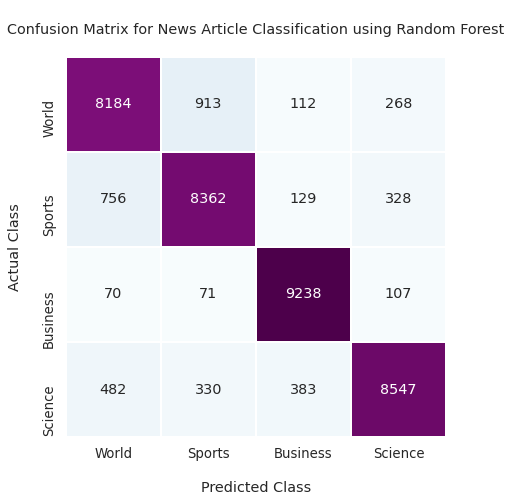

In [36]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns

sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, rf_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");
# plt.savefig('W2V Confusion Matrix for News Article Classification using Random Forest.png', bbox_inches='tight')
plt.title("\nConfusion Matrix for News Article Classification using Random Forest\n");

# Naive Bayes Classsifier

In [37]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB


# instantiate the model
gnb = GaussianNB()

print("Fitting a Naive Bayes to labeled training data...")

start_time = time()

# fit the model
gnb.fit(X_train, y_train)

nb_tt = round((time() - start_time) / 60, 2)

print('Time to train Naive Bayes Model: {} mins'.format(nb_tt))

Fitting a Naive Bayes to labeled training data...
Time to train Naive Bayes Model: 0.0 mins


In [38]:
start_time = time()

nb_result = gnb.predict(X_test)

nb_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using Naive Bayes model: {} mins'.format(nb_pt))

Time taken for label prediction using Naive Bayes model: 0.0 mins


In [39]:
nb = round(accuracy_score(y_test, nb_result)*100,3)

In [40]:
print(classification_report(y_test, nb_result))

                        precision    recall  f1-score   support

              business       0.84      0.80      0.82      9477
science_and_technology       0.81      0.81      0.81      9575
                sports       0.90      0.95      0.92      9486
                 world       0.86      0.87      0.87      9742

              accuracy                           0.86     38280
             macro avg       0.85      0.86      0.85     38280
          weighted avg       0.85      0.86      0.85     38280



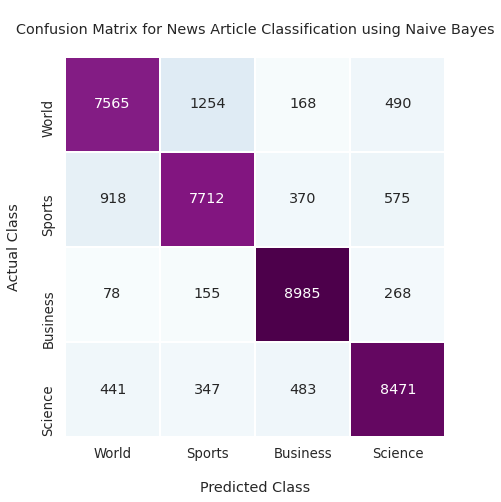

In [41]:
sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, nb_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");
# plt.savefig('W2V Confusion Matrix for News Article Classification using Naive Bayes.png', bbox_inches='tight')
plt.title("\nConfusion Matrix for News Article Classification using Naive Bayes\n");

# Logistic Regression Classifier

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
logit = LogisticRegression()

print("Fitting a Logistic Regression model to labeled training data...")

start_time = time()

logit.fit(X_train,y_train)

lr_tt = round((time() - start_time) / 60, 2)

print('Time to train Logistic Regression Model: {} mins'.format(lr_tt))


Fitting a Logistic Regression model to labeled training data...
Time to train Logistic Regression Model: 0.05 mins


In [44]:
start_time = time()

lr_result = logit.predict(X_test)

lr_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using Logistic Regression model: {} mins'.format(lr_pt))

Time taken for label prediction using Logistic Regression model: 0.0 mins


In [45]:
lr = round(accuracy_score(y_test, lr_result)*100,3)

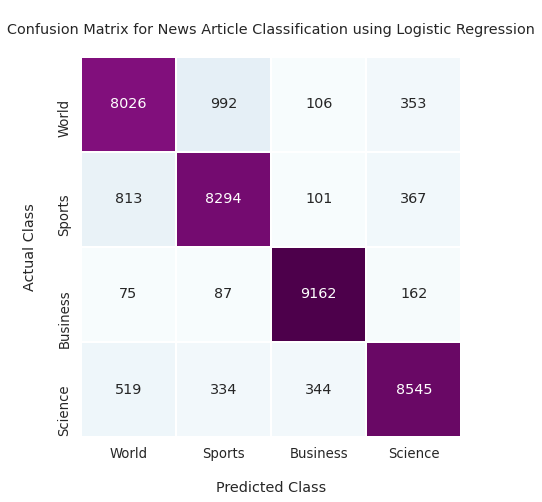

In [46]:
sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, lr_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");
# plt.savefig('W2V Confusion Matrix for News Article Classification using Logistic Regression.png', bbox_inches='tight')
plt.title("\nConfusion Matrix for News Article Classification using Logistic Regression\n");

# SVM Classifier

In [47]:
from sklearn.svm import SVC

In [48]:
svc = SVC()

print("Fitting a SVM model to labeled training data...")

start_time = time()

svc.fit(X_train,y_train)

svm_tt = round((time() - start_time) / 60, 2)

print('Time to train SVM mode: {} mins'.format(svm_tt))

Fitting a SVM model to labeled training data...
Time to train SVM mode: 5.01 mins


In [49]:
start_time = time()

svm_result = svc.predict(X_test)

svm_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using SVM model: {} mins'.format(svm_pt))

Time taken for label prediction using SVM model: 1.72 mins


In [50]:
svm = round(accuracy_score(y_test, svm_result)*100,3)

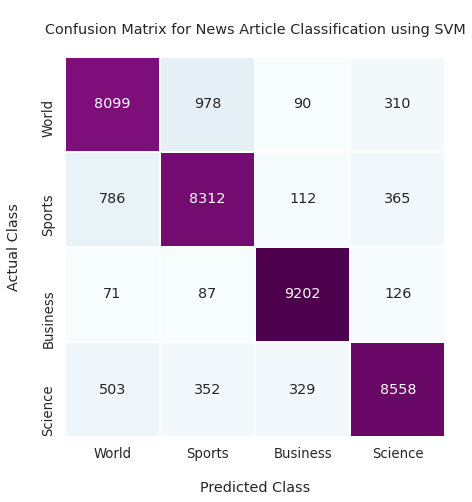

In [51]:
sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, svm_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");
# plt.savefig('W2V Confusion Matrix for News Article Classification using SVM.png', bbox_inches='tight')
plt.title("\nConfusion Matrix for News Article Classification using SVM\n");

# Comparison of models (Accuracy)

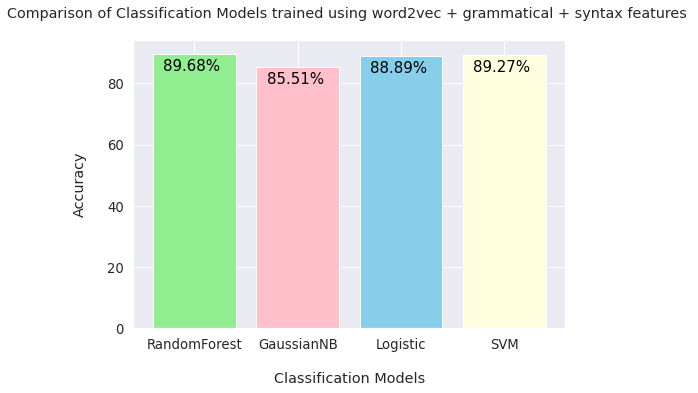

In [52]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic', 'SVM']
Accuracy=[rf,nb,lr,svm]
ax.bar(Models,Accuracy,color=["lightgreen","pink", "skyblue", "lightyellow"]);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-5.5, str(round(i.get_height(),2))+'%', fontsize=15, color='black')
plt.title('Comparison of Classification Models trained using word2vec + grammatical + syntax features \n');
plt.ylabel('Accuracy\n');
plt.xlabel('\nClassification Models');
# plt.savefig('W2V Comparison of Classification Models trained using word2vec + grammatical + syntax features.png', bbox_inches='tight')
plt.show();

# Comparison of models (Training Time)

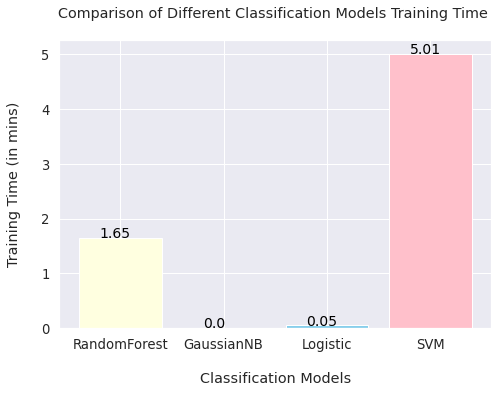

In [53]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic', 'SVM']
TrainingTime=[rf_tt,nb_tt,lr_tt,svm_tt]
ax.bar(Models,TrainingTime,color=["lightyellow","lightgreen", "skyblue", "pink"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models Training Time \n');
plt.ylabel('Training Time (in mins)\n');
plt.xlabel('\nClassification Models');
# plt.savefig('W2V Comparison of Different Classification Models Training Time.png', bbox_inches='tight')
plt.show();

# Comparison of models (Label Classification Time)

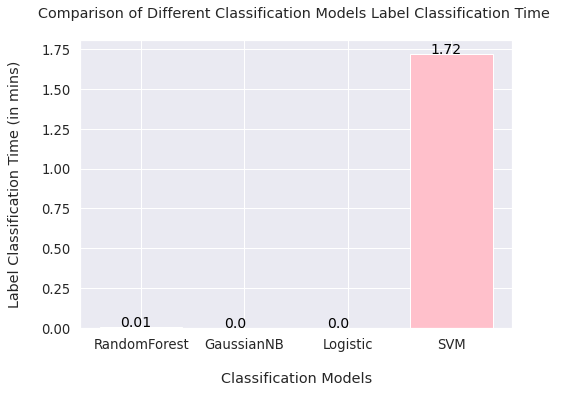

In [54]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic', 'SVM']
PredictTime=[rf_pt,nb_pt,lr_pt,svm_pt]
ax.bar(Models,PredictTime,color=["lightyellow","lightgreen", "skyblue", "pink"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models Label Classification Time \n');
plt.ylabel('Label Classification Time (in mins)\n');
plt.xlabel('\nClassification Models');
# plt.savefig('W2V Comparison of Different Classification Models Label Classification Time.png', bbox_inches='tight')
plt.show();

# Model Training & Evaluation using Cross-Validation approach

Logistic Regression

In [55]:
lr = LogisticRegression(solver='newton-cg')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lr_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    lr.fit(x_t, y_t)
    lr_acc.append(lr.score(x_v, y_v))
    
    

In [56]:
print(lr_acc)

[0.8927451858486342, 0.8921294223018361, 0.8924093148231079, 0.8928011643528885, 0.8924093148231079]


In [57]:
print(np.mean(lr_acc))

0.8924988804299149


Random Forest 

In [58]:
rf = RandomForestClassifier()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rf_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    rf.fit(x_t, y_t)
    rf_acc.append(rf.score(x_v, y_v))

In [59]:
print(rf_acc)

[0.8982870577698164, 0.8938647559337215, 0.8972234661889834, 0.8975033587102552, 0.8941446484549933]


In [60]:
print(np.mean(rf_acc))

0.896204657411554


Naive Bayes

In [61]:
gnb = GaussianNB()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
gnb_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    gnb.fit(x_t, y_t)
    gnb_acc.append(gnb.score(x_v, y_v))

In [62]:
print(gnb_acc)

[0.85910210479176, 0.8515450067174205, 0.8575906851768921, 0.8546238244514106, 0.8552955665024631]


In [63]:
print(np.mean(gnb_acc))

0.8556314375279893


SVM

In [64]:
svc = SVC()

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
svc_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    svc.fit(x_t, y_t)
    svc_acc.append(svc.score(x_v, y_v))

In [65]:
print(svc_acc)

[0.890729959695477, 0.8895432154052844]


In [66]:
print(np.mean(svc_acc))

0.8901365875503806


Model Evaluation

In [67]:
from sklearn.preprocessing import OneHotEncoder

y_test = y_test.to_numpy()
y_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test,y_pred)
lr_recall = recall_score(y_test,y_pred,average='macro')
lr_precision = precision_score(y_test,y_pred,average='macro')
lr_f1 = f1_score(y_test,y_pred,average='macro')

y_pred_roc = OneHotEncoder().fit(y_test.reshape(-1, 1)).transform(y_pred.reshape(-1,1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
lr_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [68]:
y_pred = gnb.predict(X_test)

gnb_acc = accuracy_score(y_test,y_pred)
gnb_recall = recall_score(y_test_roc,y_pred_roc,average='macro')
gnb_precision = precision_score(y_test_roc,y_pred_roc,average='macro')
gnb_f1 = f1_score(y_test_roc,y_pred_roc,average='macro')

y_pred_roc = OneHotEncoder().fit(y_test.reshape(-1, 1)).transform(y_pred.reshape(-1,1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
gnb_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')
# The multiclass and multilabel cases expect a shape (n_samples, n_classes)

In [69]:
y_pred = svc.predict(X_test)

svc_acc = accuracy_score(y_test,y_pred)
svc_recall = recall_score(y_test,y_pred,average='macro')
svc_precision = precision_score(y_test,y_pred,average='macro')
svc_f1 = f1_score(y_test,y_pred,average='macro')

y_pred_roc = OneHotEncoder().fit(y_test.reshape(-1, 1)).transform(y_pred.reshape(-1,1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
svc_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [70]:
y_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test,y_pred)
rf_recall = recall_score(y_test,y_pred,average='macro')
rf_precision = precision_score(y_test,y_pred,average='macro')
rf_f1 = f1_score(y_test,y_pred,average='macro')

y_pred_roc = OneHotEncoder().fit(y_test.reshape(-1, 1)).transform(y_pred.reshape(-1,1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
rf_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [71]:
print("Logistic Regression: ",lr_acc,lr_recall,lr_precision,lr_f1,lr_roc)
print("Naive Bayes: ", gnb_acc,gnb_recall,gnb_precision,gnb_f1,gnb_roc)
print("Support Vector Machine: ", svc_acc,svc_recall,svc_precision,svc_f1,svc_roc)
print("Random Forest: ", rf_acc,rf_recall,rf_precision,rf_f1,rf_roc)

Logistic Regression:  0.8904649947753396 0.8906151006235196 0.8904769294106861 0.8904279567650215 0.9270557375868776
Naive Bayes:  0.8551462904911181 0.8906151006235196 0.8904769294106861 0.8904279567650215 0.9034321199281004
Support Vector Machine:  0.8887147335423198 0.8888558761199834 0.88879758649877 0.8886647307569335 0.9258849603391074
Random Forest:  0.8960292580982236 0.8962028798412252 0.8959790602875873 0.8958581672798429 0.9307797293347566


# Results

In [72]:
results = pd.DataFrame([[lr_acc,lr_recall,lr_precision,lr_f1,lr_roc],
                        [gnb_acc,gnb_recall,gnb_precision,gnb_f1,gnb_roc],
                        [svc_acc,svc_recall,svc_precision,svc_f1,svc_roc],
                        [rf_acc,rf_recall,rf_precision,rf_f1,rf_roc]],
                       columns=['accuracy','recall','precision','fl-score','roc_auc'], 
                       index=["Logistic Regression","Naive Bayes","Support Vector Machine","Random Forest"])

In [73]:
results

,accuracy,recall,precision,fl-score,roc_auc
Logistic Regression,0.890465,0.890615,0.890477,0.890428,0.927056
Naive Bayes,0.855146,0.890615,0.890477,0.890428,0.903432
Support Vector Machine,0.888715,0.888856,0.888798,0.888665,0.925885
Random Forest,0.896029,0.896203,0.895979,0.895858,0.930780


In [74]:
export_file_path = os.path.abspath(os.path.join(os.pardir,'data','word2vec_results.csv'))
results.to_csv(export_file_path)